# Money Management: Stock Price Forecasting Using Neural Sequence Translation

Neural Sequence Translation (NST) is an tweak version of Recurrent Neural Network which not just forecasts a point in the future but an entire vector in the future. Just like [Neural Machine Translation](https://arxiv.org/abs/1409.0473), this notebook explores this upgrade philosophy and apply this idea in a singular stock data.

Stock price today is probably dependent on:
- The trend it has been folloing from the previous day.
- The price it was traded at from previous day.
- Some other factors that may affect stock price today.

Generalize intuition from above to the following:
- The previous cell state (i.e. the information that was present in the memory after the previous time step).
- The previous hidden state (i.e. this is the same as the output of the previous cell).
- The input at the current time step (i.e. the new information that is being fed in at that moment).

In this notebook, we cover
- Part 1 - Data Preprocessing
- Part 2 - Construct NST Architecture
- Part 3 - Predictions and Performance Visualization

A Production of [Yin's Capital](www.YinsCapital.com)

## Recurrent Neural Network (a sequential model)

Given data $X$ and $Y$, we want to feed information forward into a time stamp. Then we form some belief and we make some initial predictions. We investigate our beliefs by looking at the loss function of the initial guesses and the real value. We update our model according to error we observed. 

## Architecture: Feed-forward

Consider data with time stamp
$$X_{\langle 1 \rangle} \rightarrow X_{\langle 2 \rangle} \rightarrow \dots \rightarrow X_{\langle T \rangle}$$
and feed-forward architecture pass information through exactly as the following:
$$
\text{Information in:} \rightarrow
\begin{matrix}
\{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} & \{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} &       & \{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} \\
\updownarrow               & \updownarrow               &       & \updownarrow \\
\{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} & \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} &       & \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} \\
\uparrow               & \uparrow               &       & \uparrow \\
X_{\langle 1 \rangle} \rightarrow    & X_{\langle 2 \rangle} \rightarrow    & \dots \rightarrow & X_{\langle T \rangle} \\
\uparrow               & \uparrow               &       & \uparrow \\
w_{\langle 1 \rangle}, b_{0, \langle 1 \rangle}    & w_{\langle 2 \rangle}, b_{0, \langle 2 \rangle}    &       & w_{\langle T \rangle}, b_{0, \langle T \rangle} \\
\end{matrix}
\rightarrow
\text{Form beliefs about } Y_{\langle T \rangle}
$$
while the educated guesses $\hat{Y}_{\langle T \rangle}$ are our beliefs about real $Y$ at time stamp $T$. 

## Architecture: Feed-backward

Let us clearly define our loss function to make sure we have a proper grip of our mistakes. 
$$\mathcal{L} = \sum_t \sum_k L(\hat{y}_{\langle t,k \rangle} - y_{\langle t,k \rangle})^2$$
and we can compute the gradient 
$$\triangledown = \frac{\partial \mathcal{L}}{\partial a}$$
and then with respect with parameters $w$ and $b$
$$\frac{\partial \triangledown}{\partial w}, \frac{\partial \triangledown}{\partial a}$$
and now with perspective of where we make our mistakes according to our parameters we can go backward
$$
\text{Information in:} \leftarrow
\underbrace{
\begin{matrix}
\{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} & \{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} &       & \{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} \\
\updownarrow               & \updownarrow               &       & \updownarrow \\
\{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} & \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} &       & \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} \\
\uparrow               & \uparrow               &       & \uparrow \\
X_{\langle 1 \rangle} \leftarrow    & X_{\langle 2 \rangle} \leftarrow    & \dots \leftarrow & X_{\langle T \rangle} \\
\uparrow               & \uparrow               &       & \uparrow \\
w'_{\langle 1 \rangle}, b'_{0, \langle 1 \rangle}    & w'_{\langle 2 \rangle}, b'_{0, \langle 2 \rangle}    &       & w'_{\langle T \rangle}, b'_{0, \langle T \rangle} \\
\end{matrix}}_{\text{Update: } w, b \text{ with } w', b'}
\leftarrow
\text{Total Loss: } \mathcal{L} (\hat{y}, y)
$$
and the *update* action in the above architecture is dependent on your optimizer specified in the algorithm.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
start_date = '2013-01-01'
end_date = '2021-01-01'
ticker = 'AAPL'
w = 1
h = 5

In [3]:
stockData = yf.download(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
stockData.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.985447,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.771053,352965200


In [5]:
stockData = stockData.iloc[:,:5]

In [6]:
stockData.head(2)

,Open,High,Low,Close,Adj Close
Date,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.985447
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.771053


note:
- $X$: explanatory data matrix
- $Y$: response data matrix

In [7]:
Y = stockData.iloc[1::,]

In [8]:
Y.head(2)

,Open,High,Low,Close,Adj Close
Date,,,,,
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.771053
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.303900


In [9]:
X = stockData.iloc[0:int(stockData.shape[0]-1),]

In [10]:
X.head(2)

,Open,High,Low,Close,Adj Close
Date,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.985447
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.771053


In [11]:
cutoff = 0.95
X_train = X.iloc[0:round(X.shape[0]*cutoff), ]
X_test = X.iloc[round(X.shape[0]*cutoff):X.shape[0], ]

In [12]:
y_train = Y.iloc[0:round(Y.shape[0]*cutoff), ]
y_test = Y.iloc[round(Y.shape[0]*cutoff):Y.shape[0], ]

In [13]:
X_train = np.array(X_train).reshape(X_train.shape[0], w, h)
X_test = np.array(X_test).reshape(X_test.shape[0], w, h)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(1913, 1, 5)
(101, 1, 5)
(1913, 5)
(101, 5)


In [27]:
import tensorflow as tf

In [29]:
tf.keras.layers.AdditiveAttention

tensorflow.python.keras.layers.dense_attention.AdditiveAttention

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [59]:
regressor = Sequential()
regressor.add(LSTM(units = 128*4, return_sequences = True, input_shape = (w, h)))
regressor.add(Dropout(.3))
regressor.add(LSTM(units = 128*3, return_sequences = True))
regressor.add(Dropout(.2))
regressor.add(LSTM(units = 128*2, return_sequences = True))
regressor.add(Dropout(.1))
regressor.add(Dense(units = 128))
regressor.add(Dense(units = 64))
regressor.add(Dense(units = 32))
regressor.add(Dense(units = y_train.shape[1]))

In [60]:
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 512)            1060864   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 384)            1377792   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 384)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 256)            656384    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 1, 128)           

In [61]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [62]:
regressor.fit(X_train, y_train, epochs=120, batch_size = 32)

Epoch 1/120
60/60 [==============================] - 1s 15ms/step - loss: 525.2693
Epoch 2/120
60/60 [==============================] - 1s 16ms/step - loss: 322.4409
Epoch 3/120
60/60 [==============================] - 1s 15ms/step - loss: 325.4763
Epoch 4/120
60/60 [==============================] - 1s 15ms/step - loss: 323.9072
Epoch 5/120
60/60 [==============================] - 1s 15ms/step - loss: 324.9408
Epoch 6/120
60/60 [==============================] - 1s 16ms/step - loss: 324.7023
Epoch 7/120
60/60 [==============================] - 1s 15ms/step - loss: 325.8133
Epoch 8/120
60/60 [==============================] - 1s 15ms/step - loss: 321.3777
Epoch 9/120
60/60 [==============================] - 1s 16ms/step - loss: 326.6245
Epoch 10/120
60/60 [==============================] - 1s 15ms/step - loss: 329.4568
Epoch 11/120
60/60 [==============================] - 1s 16ms/step - loss: 324.8318
Epoch 12/120
60/60 [==============================] - 1s 15ms/step - loss: 323.7361
E

In [63]:
import mplfinance as mpf

In [64]:
predicted_stock_price = regressor.predict(X_test)

In [65]:
real_stock_price = y_test

In [66]:
predicted_stock_price.shape

(101, 1, 5)

In [67]:
predicted_stock_price = np.array(
    predicted_stock_price).reshape(predicted_stock_price.shape[0], predicted_stock_price.shape[2])


In [68]:
predicted_stock_price.shape

(101, 5)

In [69]:
predicted_stock_price = pd.DataFrame(predicted_stock_price)

predicted_stock_price.columns = real_stock_price.columns
predicted_stock_price.index = real_stock_price.index


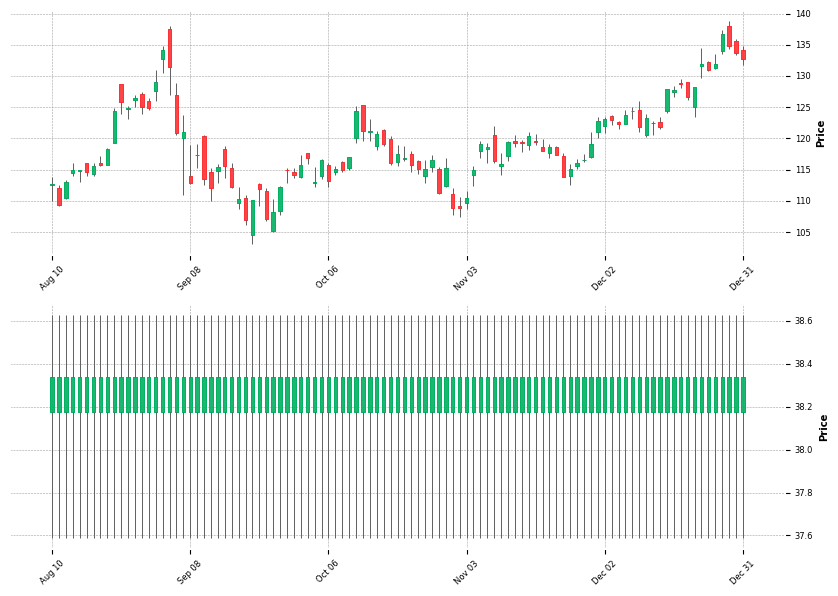

In [70]:
s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 6})
fig = mpf.figure(figsize=(10, 7), style=s) # pass in the self defined style to the whole canvas
ax = fig.add_subplot(2,1,1) # main candle stick chart subplot, you can also pass in the self defined style here only for this subplot
av = fig.add_subplot(2,1,2, sharex=ax)  # volume chart subplot

mpf.plot(real_stock_price, type = 'candle', style = 'yahoo', ax=ax, volume = False)
mpf.plot(predicted_stock_price, type = 'candle', style = 'yahoo', ax=av)

In [ ]:
!pip uninstall scipy

In [1]:
from scipy import stats

In [7]:
from YinCapital_forecast.modules import Neural_Sequence_Translation

In [8]:
tmp = Neural_Sequence_Translation(
        start_date       =   '2014-01-01',
        end_date         =   '2021-01-01',
        ticker           =   'AAPL',
        w                =   1,
        h                =   5,
        cutoff           =   0.93,
        numOfHiddenLayer =   3,
        l1_units         =   128*4,
        l2_units         =   128*3,
        l3_units         =   64*3,
        l4_units         =   30,
        l5_units         =   10,
        dropOutRate       =  0.3,
        optimizer        =   'adam',
        loss             =   'mean_squared_error',
        epochs           =   120,
        batch_size       =   64,
        plotGraph        =   False,
        useMPLFinancePlot=   True,
        verbose          =   True )

------------------------------------------------------------------------------

            MANUAL: To install this python package, please use the following code.

            # In a python notebook:
            # !pip install git+https://github.com/yiqiao-yin/YinPortfolioManagement.git
            # In a command line:
            # pip install git+https://github.com/yiqiao-yin/YinPortfolioManagement.git

            # Run
            tmp = Neural_Sequence_Translation(
                start_date       =   '2013-01-01',
                end_date         =   '2021-01-01',
                ticker           =   'AAPL',
                w                =   1,
                h                =   5,
                cutoff           =   0.8,
                numOfHiddenLayer =   3,
                numOfDense       =   2,
                l1_units         =   50,
                l2_units         =   50,
                l2_units         =   50,
                l3_units         =   50,
             

ImportError: cannot import name '__version__' from partially initialized module 'keras' (most likely due to a circular import) (C:\Users\eagle\anaconda3\lib\site-packages\keras\__init__.py)